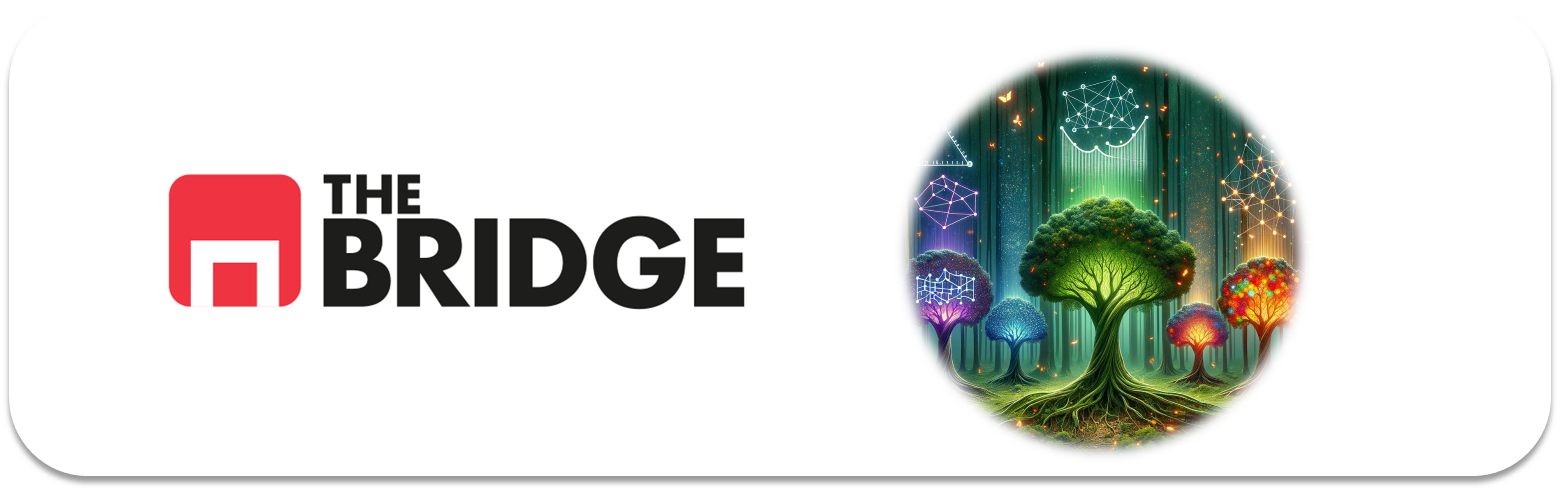

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    # Filtra solo las columnas que están en categoricas_destacadas
    columnas_categoricas = [col for col in columnas_categoricas if col in categoricas_destacadas]
    
    num_columnas = 2 
    num_filas = (len(columnas_categoricas) + num_columnas - 1) // num_columnas  # Calcula el número de filas necesario

    fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 5 * num_filas))  # Ajusta el tamaño del subplot
    axes = axes.flatten()  # Aplanar el array de axes para un manejo más fácil

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if isinstance(df[col].iloc[0], list):  # Verificar si el elemento es una lista
            temp_df = df.explode(col)
        else:
            temp_df = df

        serie = temp_df[col].value_counts()
        if relativa:
            total = serie.sum()
            serie = serie.apply(lambda x: x / total)
            ax.set_ylabel('Frecuencia Relativa')
        else:
            ax.set_ylabel('Frecuencia')

        # Usar la paleta 'viridis' y asignar 'x' a 'hue'
        sns.barplot(x=serie.index, y=serie, hue=serie.index, ax=ax, palette='viridis', legend=False)
        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')  # Ocultar ejes no utilizados

    plt.tight_layout()
    plt.show()

In [3]:
def plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=False, show_values=False, size_group = 5):
    # Prepara los datos
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    # Convierte a frecuencias relativas si se solicita
    if relative_freq:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    # Si hay más de size_group categorías en cat_col1, las divide en grupos de size_group
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Selecciona un subconjunto de categorías para cada gráfico
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Crea el gráfico
            plt.figure(figsize=(10, 6))
            ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=data_subset, order=categories_subset)

            # Añade títulos y etiquetas
            plt.title(f'Relación entre {cat_col1} y {cat_col2} - Grupo {i + 1}')
            plt.xlabel(cat_col1)
            plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
            plt.xticks(rotation=45)

            # Mostrar valores en el gráfico
            if show_values:
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                                textcoords='offset points')

            # Muestra el gráfico
            plt.show()
    else:
        # Crea el gráfico para menos de size_group categorías
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data)

        # Añade títulos y etiquetas
        plt.title(f'Relación entre {cat_col1} y {cat_col2}')
        plt.xlabel(cat_col1)
        plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
        plt.xticks(rotation=45)

        # Mostrar valores en el gráfico
        if show_values:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                            textcoords='offset points')

        # Muestra el gráfico
        plt.show()

In [4]:
df = pd.read_csv("./data/bank-full.csv", delimiter=';')

In [5]:
def plot_combined_graphs(df, columns, whisker_width=1.5, bins = None):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0], bins= "auto" if not bins else bins)
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

### Obtener y ojear los datos

In [6]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
df["y"].unique()

array(['no', 'yes'], dtype=object)

In [9]:
df["y"].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [10]:
df["pdays"].unique()

array([ -1, 151, 166,  91,  86, 143, 147,  89, 140, 176, 101, 174, 170,
       167, 195, 165, 129, 188, 196, 172, 118, 119, 104, 171, 117, 164,
       132, 131, 123, 159, 186, 111, 115, 116, 173, 178, 110, 152,  96,
       103, 150, 175, 193, 181, 185, 154, 145, 138, 126, 180, 109, 158,
       168,  97, 182, 127, 130, 194, 125, 105, 102,  26, 179,  28, 183,
       155, 112, 120, 137, 124, 187, 190, 113, 162, 134, 169, 189,   8,
       144, 191, 184, 177,   5,  99, 133,  93,  92,  10, 100, 156, 198,
       106, 153, 146, 128,   7, 121, 160, 107,  90,  27, 197, 136, 139,
       122, 157, 149, 135,  30, 114,  98, 192, 163,  34,  95, 141,  31,
       199,  94, 108,  29, 268, 247, 253, 226, 244, 239, 245, 204, 231,
       238, 258, 230, 254, 265,  71, 223, 246, 250, 266, 240, 205, 261,
       259, 241, 260, 234, 251, 225, 161, 237, 262, 248, 255, 220, 227,
       206, 224, 249, 235, 228, 263,   2, 270, 232, 252, 207, 200, 269,
       233, 256, 273, 272, 242, 264, 208, 214, 222, 271, 203, 22

In [11]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Hay rangos muy variados de variables numéricas (edad, balance)

### Limpieza (de momento, nada que hacer en este apartado, ya están limpios)

### Split Train / Test

La variable target será "y"

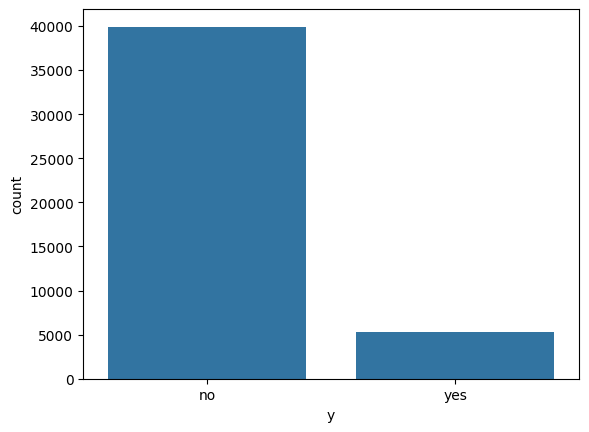

In [12]:
sns.countplot(data=df, x='y');

In [13]:
X = df.drop(['y'], axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42) 

### Mini EDA

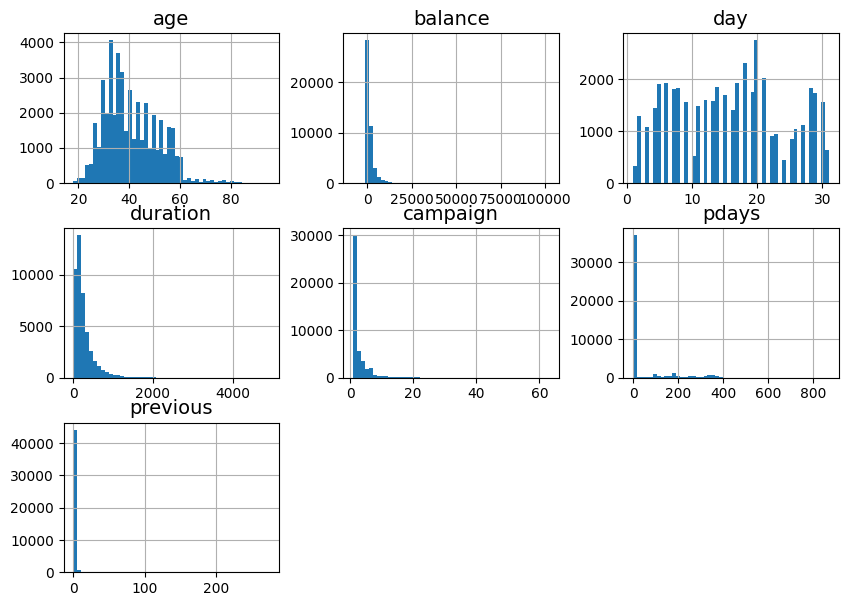

In [14]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(10,7))
plt.show()

Además de las diferentes escalas, hay muchas variables con long tail y agrupadas en pico a la izquierda

##### A ver qué pinta tienen nuestras variables categóricas

Primero voy a tratar los valores unknown

In [15]:
X_train["job"].unique()

array(['blue-collar', 'technician', 'admin.', 'management', 'services',
       'unemployed', 'housemaid', 'retired', 'entrepreneur', 'unknown',
       'student', 'self-employed'], dtype=object)

In [16]:
job_mode = X_train["job"].mode()[0]

In [17]:
X_train['job'] = X_train['job'].replace('unknown', job_mode)


In [18]:
X_train["marital"].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [19]:
X_train["education"].unique()

array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

In [20]:
education_mode = X_train["education"].mode()[0]

In [21]:
X_train['education'] = X_train['education'].replace('unknown', education_mode)

In [22]:
X_train["month"].unique()

array(['may', 'jul', 'jun', 'apr', 'aug', 'nov', 'sep', 'feb', 'oct',
       'jan', 'dec', 'mar'], dtype=object)

In [23]:
X_train["poutcome"].unique()

array(['unknown', 'success', 'failure', 'other'], dtype=object)

In [24]:
poutcome_mode = X_train["poutcome"].mode()[0]

In [25]:
# X_train['poutcome'] = X_train['poutcome'].replace('unknown', poutcome_mode)

No me queda claro qué debería hacer con esta columna, ya que la inmensa mayoría de los valores son unknown... la elimino?

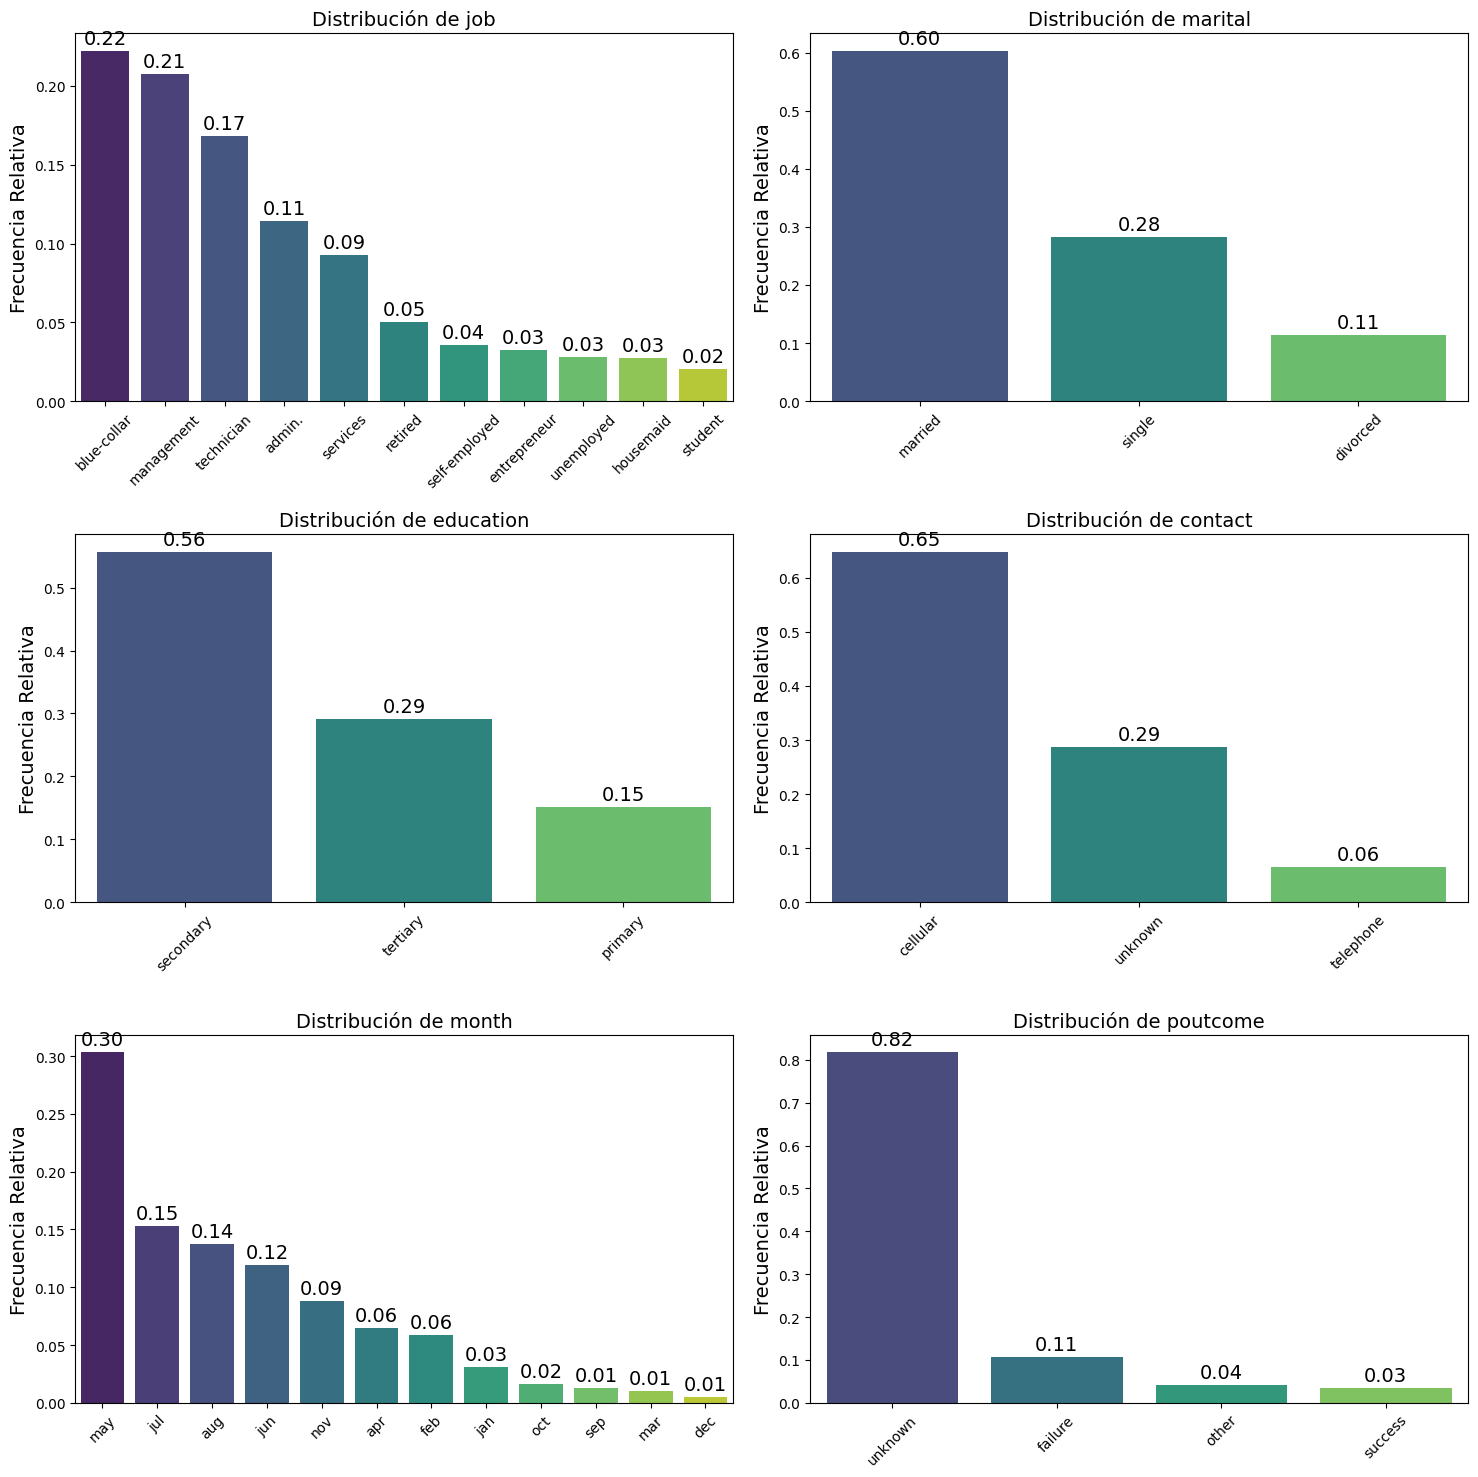

In [26]:
categoricas_destacadas = ["job","marital", "education", "contact", "month", "poutcome"]
pinta_distribucion_categoricas(X_train, ["job","marital", "education", "contact", "month", "poutcome"], relativa= True, mostrar_valores= True)

##### Y ahora veamos cómo se relacionan con el target

In [27]:
df_eda = X_train.copy()
df_eda["y"] = y_train.copy()

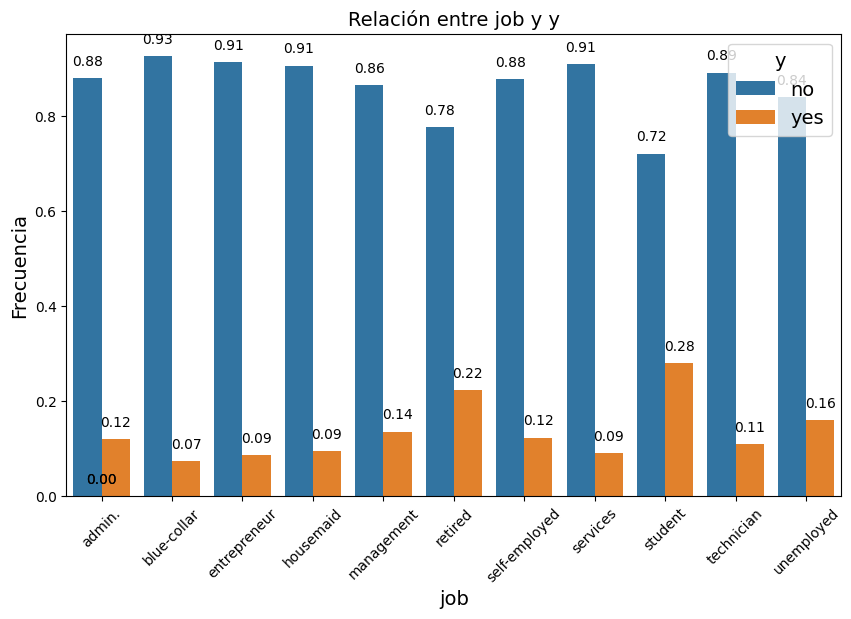

In [28]:
plot_categorical_relationship_fin(df_eda,"job", "y", show_values = True, relative_freq = True, size_group = 12)

Los que no son trabajadores en activo (students y retired) son los que más suben en y. Blue collar y services son los que menos "yes"

A primera vista, esta variable "job" si parece incidir en "y"

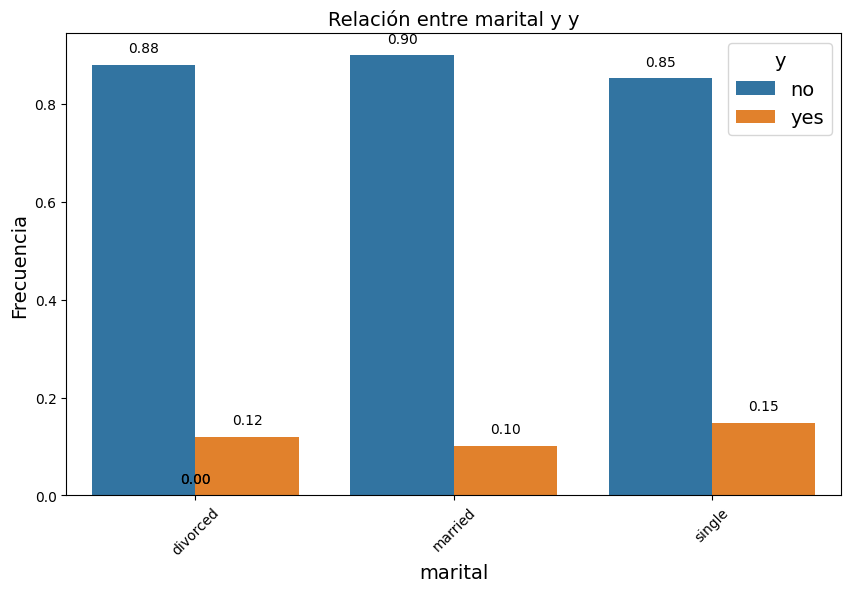

In [29]:
plot_categorical_relationship_fin(df_eda,"marital", "y", show_values = True, relative_freq = True, size_group = 12)

La relación entre "y" y "marital" parece tener un cierto efecto, aunque leve. Mientras más "sola" una persona, más propensa a yes.

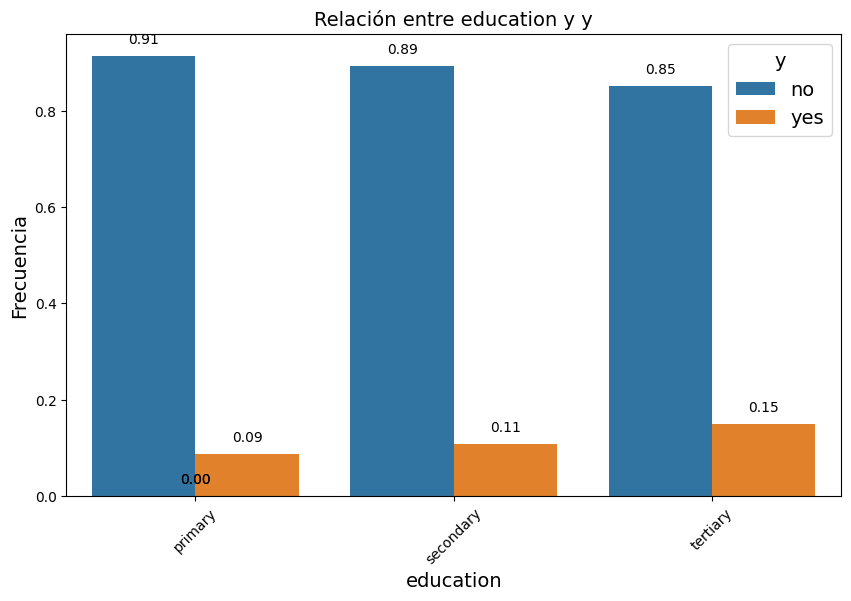

In [30]:
plot_categorical_relationship_fin(df_eda,"education", "y", show_values = True, relative_freq = True, size_group = 12)

A mayores estudios, mayor tendencia a yes en "y"

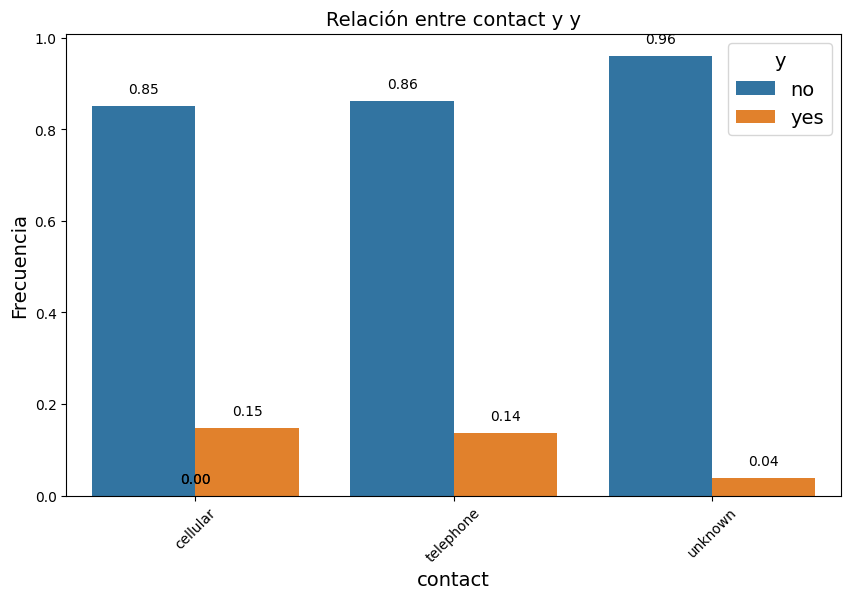

In [31]:
plot_categorical_relationship_fin(df_eda,"contact", "y", show_values = True, relative_freq = True, size_group = 12)

Excepto los unknown, los demás tipos de contacto tienen ratios muy similres de yes. Eliminaré esta feature

In [32]:
X_train.drop('contact', axis=1, inplace=True)

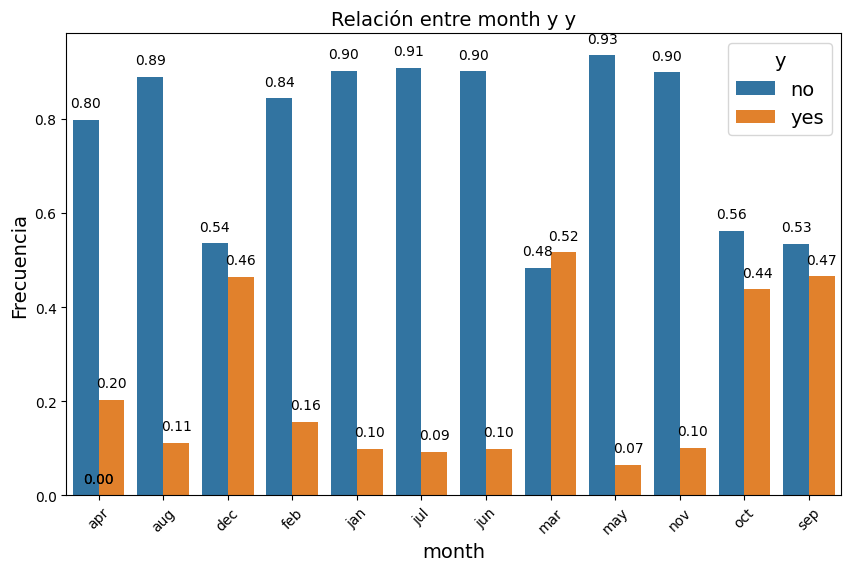

In [33]:
plot_categorical_relationship_fin(df_eda,"month", "y", show_values = True, relative_freq = True, size_group = 12)

En los meses de marzo, septiembre, octubre y diciembre hay mucha más frecuencia de yes que en los demás meses, y son los meses en que menos cifras absolutas hay. Especialmente bajas son las cifras de mayo que es cuando más cifras absolutas hay.

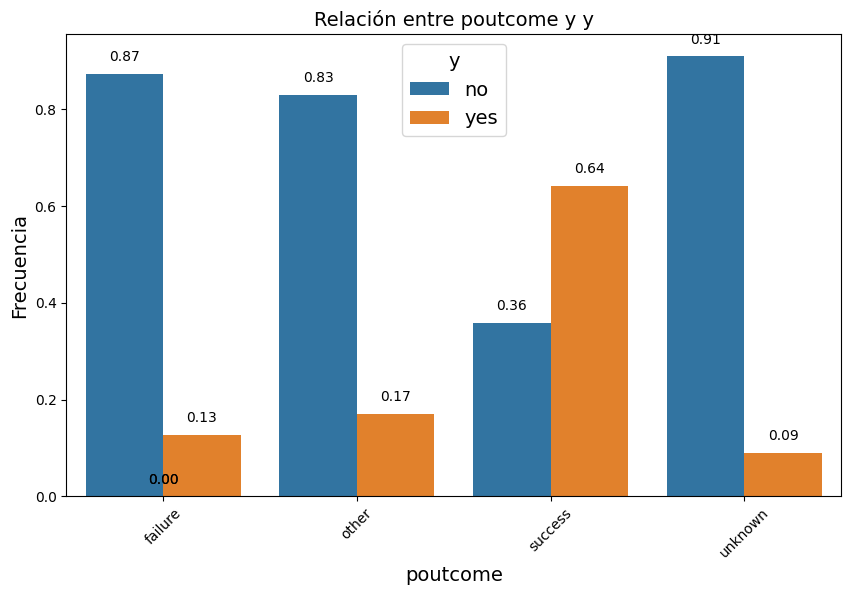

In [34]:
plot_categorical_relationship_fin(df_eda,"poutcome", "y", show_values = True, relative_freq = True, size_group = 12)

Hay una muy clara relación entre estas variables. Un success anteriorse vincula muy fuertemente con un éxito en esta otra campaña. Pero... en esta columna es donde mayor vantidad de unknows hay...

#### Haré un comparación similar con las binarias

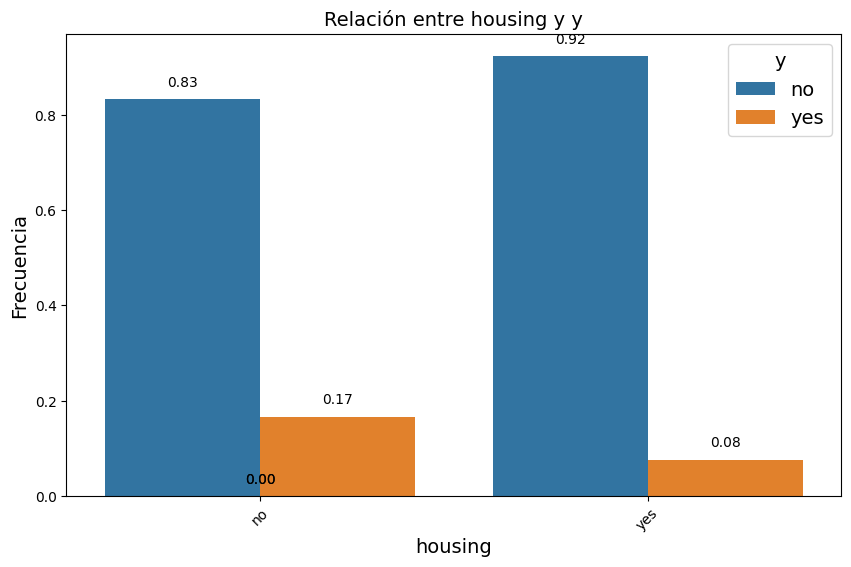

In [35]:
plot_categorical_relationship_fin(df_eda,"housing", "y", show_values = True, relative_freq = True, size_group = 12)

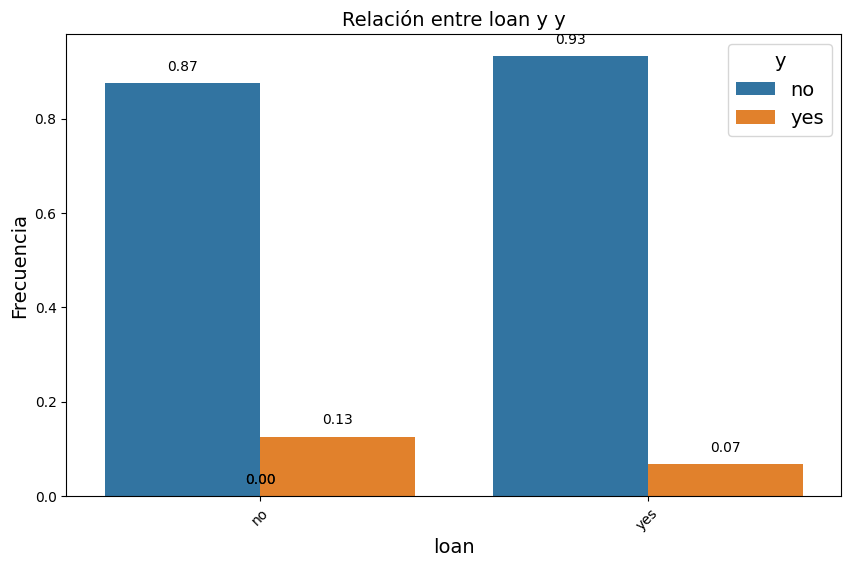

In [36]:
plot_categorical_relationship_fin(df_eda,"loan", "y", show_values = True, relative_freq = True, size_group = 12)

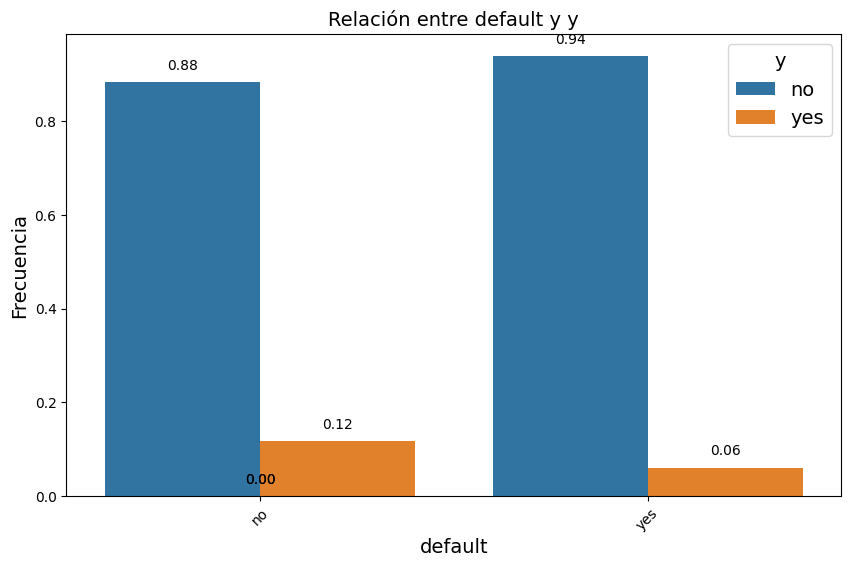

In [37]:
plot_categorical_relationship_fin(df_eda,"default", "y", show_values = True, relative_freq = True, size_group = 12)

Estas 3 binarias tienen valores muy similares, pero no sé aún si es coincidencia o colinealidad. Lo miro más abajo...

##### Ahora veamos la relación entre las variables numéricas y el target

Primero voy a convertir la variable target en numérica

In [38]:
df_eda['y'] = df_eda['y'].map({'yes': 1, 'no': 0})

In [39]:
y_train = y_train.map({'yes': 1, 'no': 0})
# también en el target

In [40]:
corr_matrix = df_eda.corr(numeric_only= True)
corr_matrix["y"].abs().sort_values(ascending = False)

y           1.000000
duration    0.393402
pdays       0.105742
previous    0.092051
campaign    0.072571
balance     0.052518
age         0.026684
day         0.025887
Name: y, dtype: float64

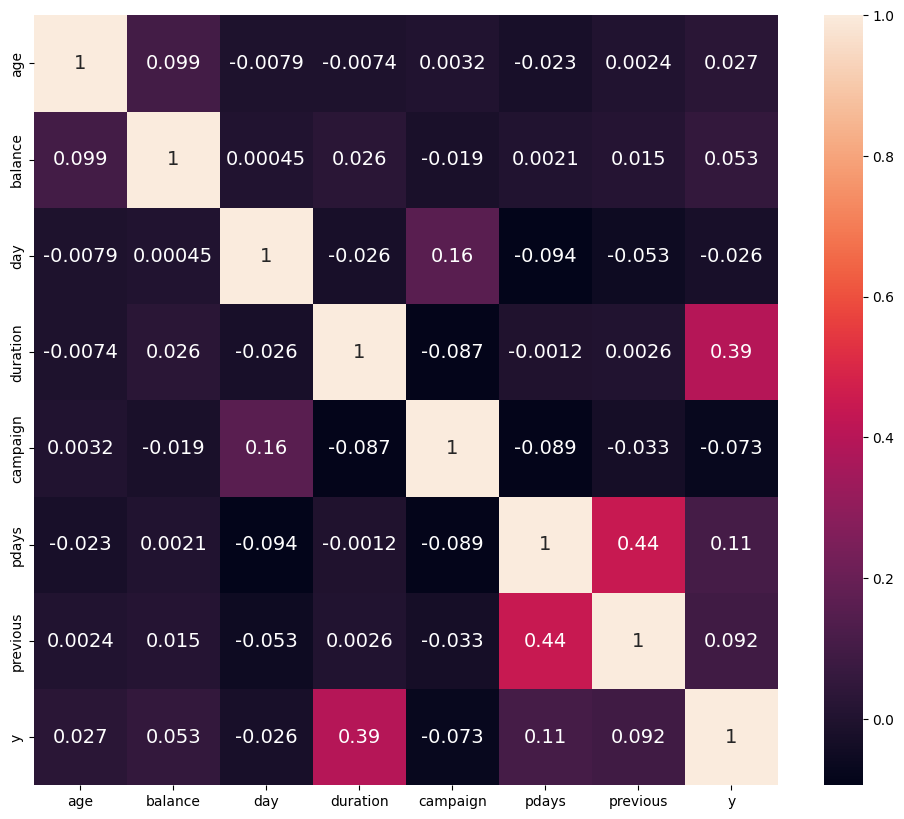

In [41]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_eda.corr(numeric_only = True),annot=True);
plt.show();

In [42]:
X_train.drop('previous', axis=1, inplace=True)

In [43]:
columnas_num = corr_matrix["y"][corr_matrix["y"] > 0.025].index.to_list()
columnas_num.remove("previous")
columnas_num.remove( "y")

columnas_num

['age', 'balance', 'duration', 'pdays']

No veo que ninguna tenga correlación demasiado alta... la que más es apenas 0.39, por lo que bajoel umbral a 0.025, pero suena a dejar entrar casi todo por si alguna combinación de esas variables resulta más significativa. Sí que pdays y previous parecen correlar (ambas hacen referencia a los contactos anteriores con el cliente) por lo que eliminaré una, y me quedo con pdays, que es algo mayor que previous.

### Tratar las features

#### Tratamiento de las variables categóricas

Las trataré con One-Hot Encoding ya que no hay lógica ordinal entre los diferentes valores de las variables categóricas

In [44]:
categoricas_destacadas.remove("contact")

In [45]:
pd.get_dummies(X_train, columns=['job', 'marital', 'education', 'month', 'poutcome']
).head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3344,41,no,849,yes,no,15,72,1,-1,False,...,False,False,True,False,False,False,False,False,False,True
17965,49,no,1415,yes,no,30,269,2,-1,False,...,False,False,False,False,False,False,False,False,False,True
18299,42,no,3842,no,no,31,130,4,-1,True,...,False,False,False,False,False,False,False,False,False,True
10221,37,no,-119,yes,no,11,375,11,-1,False,...,True,False,False,False,False,False,False,False,False,True
32192,56,no,3498,no,no,15,264,2,-1,False,...,False,False,False,False,False,False,False,False,False,True


In [46]:
pd.get_dummies(X_train, columns=['job', 'marital', 'education', 'month', 'poutcome'], dtype= int).head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3344,41,no,849,yes,no,15,72,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
17965,49,no,1415,yes,no,30,269,2,-1,0,...,0,0,0,0,0,0,0,0,0,1
18299,42,no,3842,no,no,31,130,4,-1,1,...,0,0,0,0,0,0,0,0,0,1
10221,37,no,-119,yes,no,11,375,11,-1,0,...,1,0,0,0,0,0,0,0,0,1
32192,56,no,3498,no,no,15,264,2,-1,0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
train_set_bck = X_train.copy()
X_train = pd.get_dummies(X_train, columns = ['job', 'marital', 'education', 'month', 'poutcome'], dtype = int)

#### Tratamiento de las variables binarias

In [48]:
X_train['housing'] = X_train['housing'].map({'yes': 1, 'no': 0})

In [49]:
X_train['loan'] = X_train['loan'].map({'yes': 1, 'no': 0})

In [50]:
X_train['default'] = X_train['default'].map({'yes': 1, 'no': 0})

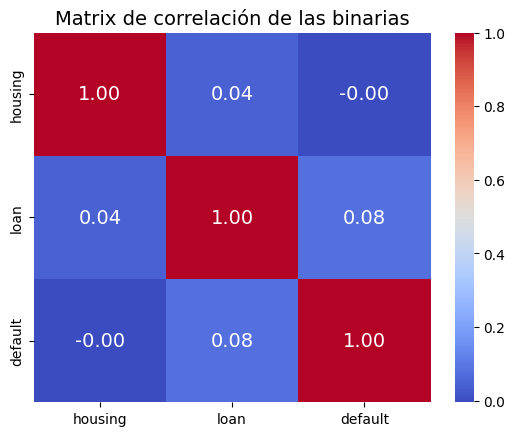

In [51]:
matriz_corr = X_train[['housing', 'loan', 'default']].corr()
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrix de correlación de las binarias')
plt.show()

In [52]:
tabla_contingencia = pd.crosstab(X_train['default'], X_train['loan'])
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
print(f"Chi-squared Test between var1 and var2: chi2={chi2}, p-value={p}")

Chi-squared Test between var1 and var2: chi2=218.92603324959964, p-value=1.551120986024494e-49


In [53]:
tabla_contingencia = pd.crosstab(X_train['housing'], X_train['loan'])
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
print(f"Chi-squared Test between var1 and var2: chi2={chi2}, p-value={p}")

Chi-squared Test between var1 and var2: chi2=70.17279118465453, p-value=5.433068102571867e-17


In [54]:
tabla_contingencia = pd.crosstab(X_train['default'], X_train['housing'])
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
print(f"Chi-squared Test between var1 and var2: chi2={chi2}, p-value={p}")

Chi-squared Test between var1 and var2: chi2=0.6585941557050647, p-value=0.4170566983024614


Todos estos tests parecerían indicar que no hay colinealidad entre éstas tres binarias, por lo que las dejo en la lista de features

#### Tratamiento de variables numéricas

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'pdays'}>]], dtype=object)

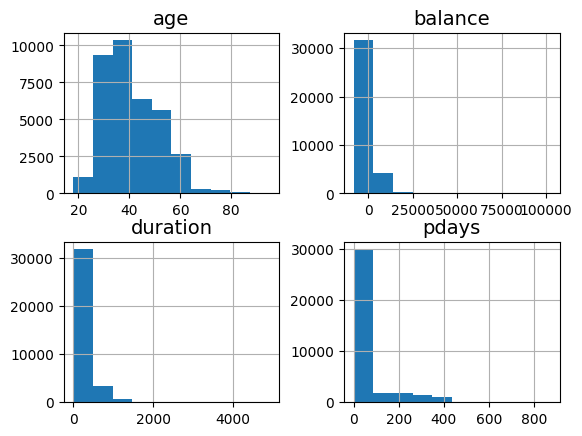

In [55]:
X_train[columnas_num].hist()

In [56]:
features_num = ['age', 'balance', 'duration', 'pdays']
constants = {'age': 1, 'balance': 8020, 'duration': 1, 'pdays': 2}
scaler = StandardScaler()


for col in features_num:
    X_train[f"log_{col}"] = np.log(X_train[col] + constants[col])

    print(f"Inf in log_{col}: ", np.isinf(X_train[f"log_{col}"]).sum())
    print(f"-Inf in log_{col}: ", np.sum(np.isneginf(X_train[f"log_{col}"])))

    X_train[col] = scaler.fit_transform(X_train[[f"log_{col}"]])
    print(f"NaN in {col} after scaling: ", X_train[col].isnull().sum())

    X_train.drop(columns=[f"log_{col}"], inplace=True)

Inf in log_age:  0
-Inf in log_age:  0
NaN in age after scaling:  0
Inf in log_balance:  0
-Inf in log_balance:  0
NaN in balance after scaling:  0
Inf in log_duration:  0
-Inf in log_duration:  0
NaN in duration after scaling:  0
Inf in log_pdays:  0
-Inf in log_pdays:  0
NaN in pdays after scaling:  0


Le he tenido que aplicar la constante a los valores antes de hacer la transformación logarítimica porque de lo contrario las variables que tenían valores negativos o iguales a 0 daban error. Y luego de eso he hecho el escalado.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'pdays'}>]], dtype=object)

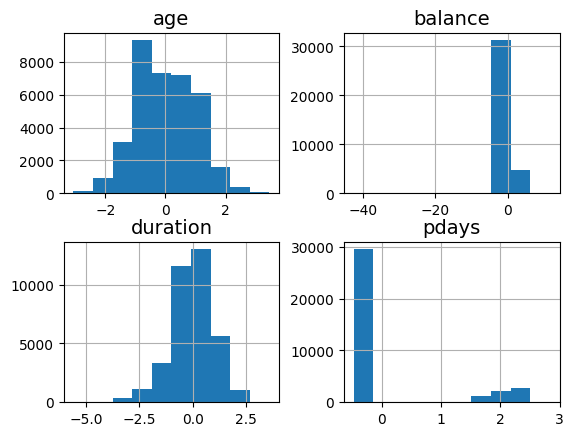

In [57]:
X_train[features_num].hist()

In [58]:
X_train.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'month_apr', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [59]:
features = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown']

### Selección de un conjunto de modelos

In [60]:
log_reg = LogisticRegression()
tree_reg = DecisionTreeRegressor(random_state = 42)

In [61]:
log_reg.fit(X_train,y_train)
tree_reg.fit(X_train,y_train)

c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DecisionTreeRegressor(random_state=42)

In [62]:
train_pred_log = log_reg.predict(X_train)

train_pred_tree = tree_reg.predict(X_train)

In [63]:
train_pred_log
# algo no está bien...

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [64]:
train_pred_tree
# algo no está bien...

array([0., 0., 0., ..., 0., 0., 0.])

In [65]:
#mse_log = mean_squared_error(y, train_pred_log, squared=False)
#print(mse_log)
# algo no está bien... Y siceramente ya no sé qué estoy haciendo

In [66]:
#mse_tree = mean_squared_error(y, train_pred_tree, squared= False)
#print(mse_tree)
# algo no está bien...

Y ahora con el árbol

In [67]:
tree_clf = DecisionTreeClassifier(max_depth=10,
                                  random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

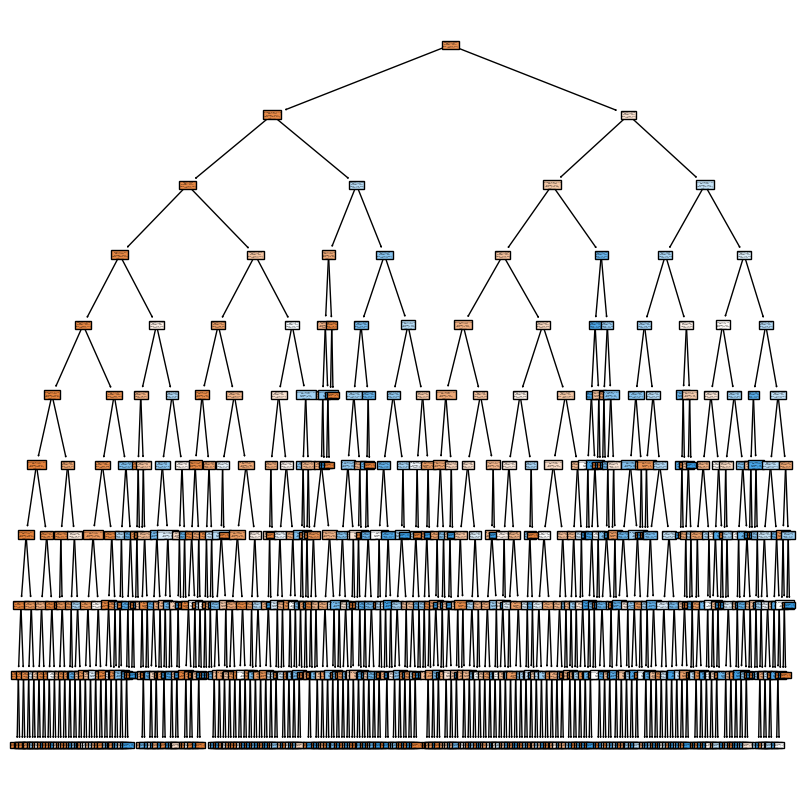

In [68]:
plt.figure(figsize=(10,10))
tree.plot_tree(tree_clf,
               feature_names=features,
               class_names=np.unique(y).astype(str),
               filled=True)
plt.show()

No creo que buscáramos esto!!

In [69]:
plt.figure(figsize=(20,20))
plot_tree(tree_reg);

Error in callback <function flush_figures at 0x0000023425DD72E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
# no tengo idea qué me está mostrando este otro árbol---

In [ ]:
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [ ]:
y_pred = tree_reg.predict(X_train)

print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

MAE: 0.15315344591189892
RMSE: 0.27672499517743143


In [ ]:
tree_reg_2 = DecisionTreeRegressor(max_depth=5, random_state=42) 
tree_reg_2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
tree_reg_3 = DecisionTreeRegressor(max_depth=10, random_state=42) 
tree_reg_3.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [ ]:
tree_reg_4 = DecisionTreeRegressor(max_depth=12, random_state=42) 
tree_reg_4.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=12, random_state=42)

### Entrenamiento con cross validation y comparación y selección del mejor

In [ ]:
level_3 = np.sqrt(-cross_val_score(tree_reg, X_train, y_train, cv = 5, scoring= "neg_mean_squared_error"))
level_5 = np.sqrt(-cross_val_score(tree_reg_2, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error"))
level_10 = np.sqrt(-cross_val_score(tree_reg_3, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error"))
level_12 = np.sqrt(-cross_val_score(tree_reg_4, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error"))
# vamos a decidir el k, que se dice con "cv" de cross validation

print("Arbol 3 niveles:", level_3.mean())
print("Arbol 5 niveles:", level_5.mean())
print("Arbol 10 niveles:", level_10.mean())
print("Arbol 12 niveles:", level_12.mean())

Arbol 3 niveles: 0.2784470526474914
Arbol 5 niveles: 0.27302184079705605
Arbol 10 niveles: 0.28314820300075716
Arbol 12 niveles: 0.29529958279643076


In [ ]:
classification_report(y_test, y_train)

NameError: name 'classification_report' is not defined

¿Esto indica que en solo 3 niveles el resultado era mejor?

In [ ]:
train_pred_log = log_reg.predict(X_train)
mse_log = mean_squared_error(y_train, train_pred_log, squared=False) 
print(mse_log)
# algo no está bien...

0.31170131291282216


c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
log_rmses = -cross_val_score(log_reg, X_train, y_train,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(log_rmses).describe()
# Claramente esto no va bien...

c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

count    10.000000
mean      0.313444
std       0.004244
min       0.306144
25%       0.310960
50%       0.312865
75%       0.315264
max       0.319835
dtype: float64

In [ ]:
# Train error:
pred_train = lm.predict(X_train)
print('MAE train', metrics.mean_absolute_error(y_train, pred_train))
print('MSE train', metrics.mean_squared_error(y_train, pred_train))
print('RMSE train', np.sqrt(metrics.mean_squared_error(y_train, pred_train)))
print('R2 train', lm.score(X_train,y_train))

# Ya no sé qué estoy copiando y pegando, se me confunde todo ahora mismo
# esto es de haber copiado esta fórmula de un notebook de Jaime sin saber ya de dónde viene ni a 
# cuento de qué

NameError: name 'lm' is not defined

In [ ]:
# Test error:
# Ahora me doy cuenta de que no hice en x_test las mismas transfomaciones!!
# Igual tengo tantos errores que me centraré en los anteriores primero...
print('MAE test', metrics.mean_absolute_error(y_test, predictions))
print('MSE test', metrics.mean_squared_error(y_test, predictions))
print('RMSE test', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 test', lm.score(X_test,y_test))

NameError: name 'predictions' is not defined

### Optimización de hiperparámetros de éste mejor

In [71]:
param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0,1,0.01)
}

elastic = ElasticNet()

random_search = RandomizedSearchCV(elastic, 
                                   param_grid, 
                                   random_state=1,
                                   n_iter=100, 
                                   cv=5,
                                   scoring="neg_root_mean_squared_error", 
                                   n_jobs = -1 
                                  )

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1e-10, 0.0001, 0.01, 1, 5, 10,
                                                  20, 40],
                                        'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
                   random_state=1, scoring='neg_root_mean_squared_error')

Aplicaría un Random search porque tengo muchas variables / features y en esos casos suele ser más indicado este modelo.

Me gustaría pder hacer la comparación con la regresión logística sin optimizar, pero es que todo me está dando error

Valoración de resultados: con tanto error solo puedo valorar mi resultado, que es  mucho empeño y muchas horas de dedicación, a pesar de los fallos :/